# Initial Conditions for an N-Body Simulation

Let's generate a realization of a Hernquist (1990) profile for a dark matter halo with total mass $M=10^{12}\,M_{\odot}$ and scale radius $a=35\,{\rm kpc}$ using $N=10^6$ particles.

In [1]:
# %matplotlib inline
import numpy
import matplotlib 
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline as US
import scipy.integrate as s_int
import time
from math import factorial
from scipy.integrate import cumulative_trapezoid

time0=time.time()

# total number of particles
nptot=10**6
# total mass of halo (in M_sun)
mtot=1e12
# Hernquist scale radius (in kpc)
aa=35.0

# Newton's constant, where M is in M_sun, v is in km/s, and r is in kpc:
gn=4.30071e-6

In [2]:
# set random state for reproducible results:
my_randState=numpy.random.RandomState(seed=0)

The basic idea is that we want to draw $(x,y,z)$ such that the radii $r=\sqrt{x^2+y^2+z^2}$ are distributed as $\rho_{\rm Hern}(r)$.

# Drawing positions

The probability of a randomly selected particle having a radius $r$ is just propotional to the probability of finding a mass element at radius $r$: 
$$dP \propto dM = 4\pi r^2\,\rho(r) \,dr\,$$
This means we can randomly select radii $r$ by randomly selecting numbers from a uniform distribution between $0$ and $M$, then finding the corresponding radius. That is, we want to find $r$ corresponding to each $M$.

Fortunately, it is easy to invert $M(r)$ to get $r(M)$:
$$r(M)=\frac{1}{M^{-1/2}-1}$$

In the lines below, I select the random numbers, then find the corresponding radii. 

In [3]:
randvs_r=my_randState.rand(nptot)
rvals=numpy.sort(1/(randvs_r**(-0.5)-1.))

Now I have a radius for each particle. I need to convert from spherical to cartesian coordinates:

In [4]:
rvals *= aa

# random numbers for phi, theta, v_phi, v_theta:
new_randvec=my_randState.rand(2, nptot)

pos=numpy.zeros((nptot, 3), dtype='float32')

phir=2e0*numpy.pi*new_randvec[0]
thetar=numpy.arccos(1e0-2e0*new_randvec[1])

pos[:,0]=rvals*numpy.sin(thetar)*numpy.cos(phir)
pos[:,1]=rvals*numpy.sin(thetar)*numpy.sin(phir)
pos[:,2]=rvals*numpy.cos(thetar)

ttot=time.time()-time0
print('total time elapsed: {0:.2f} seconds'.format(ttot))

total time elapsed: 0.33 seconds


OK, that's it! We've got a code that sets up positions for a Hernquist dark matter halo (?) with $10^6$ particles that runs in a few seconds. 

# Some tests

I'll test that we have the right mass distribution by comparing directly to the Hernquist profile. I'll bin up the halo profile in equally spaced logarithmic bins (note the function is basically a power-law, so log bins make much more sense than linear):

In [5]:
minlogr=numpy.log10(rvals.min())
maxlogr=numpy.log10(rvals.max())
# binsize, in log10:
logbinsize=0.15
binedges=numpy.r_[minlogr:maxlogr:logbinsize]

numbins=binedges.size-1
rhobinned, edges_test=numpy.histogram(numpy.log10(rvals), binedges)

In [6]:
numpy.allclose(binedges, edges_test)

True

To get density, we use 

$$\rho(r)=\frac{dM}{4\pi\,r^3\,d\log\,r}$$

This applies to a density estimate calculated at the (logarithmic) midpoint of the bin.

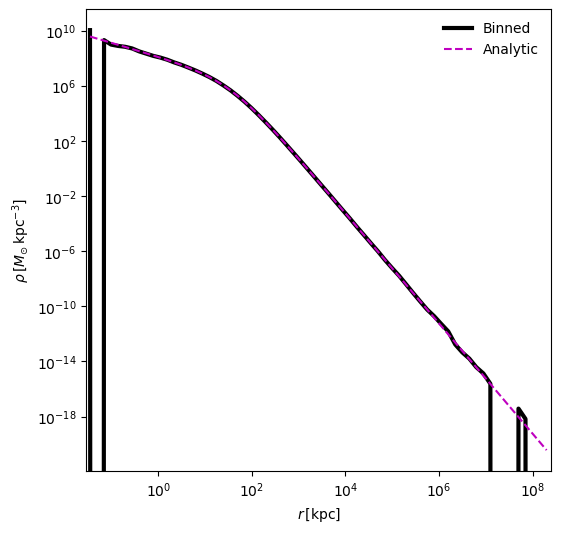

In [7]:
bincenters=10.**(binedges[:-1]+logbinsize/2.0)
rho=rhobinned*(mtot/nptot)/4./numpy.pi/logbinsize/numpy.log(10)/bincenters**3
def hernquist_rho(rr): return mtot/2/numpy.pi/aa**3/(rr/aa)/(1+rr/aa)**3
plt.figure(figsize=(6,6))
plt.loglog(bincenters, rho, 'k-', lw=3, label='Binned')
plt.loglog(bincenters, hernquist_rho(bincenters), 'm--', lw=1.5, label='Analytic')
plt.xlim(10.**(minlogr), 10.**(maxlogr))
plt.xlabel(r'$r\,[{\rm kpc}]$')
plt.ylabel(r'$\rho\,[M_{\odot}\,{\rm kpc}^{-3}]$')
plt.legend(frameon=False)

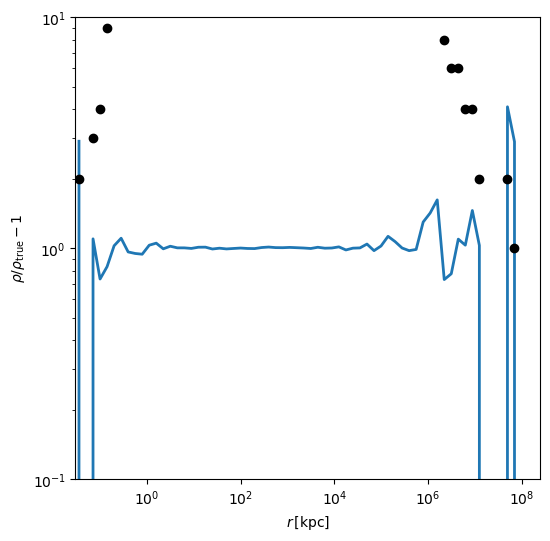

In [8]:
plt.figure(figsize=(6,6))
plt.loglog(bincenters, rho/hernquist_rho(bincenters), lw=2)
plt.xlim(10.**(minlogr), 10.**(maxlogr))
plt.xlabel(r'$r\,[{\rm kpc}]$')
plt.ylabel(r'$\rho/\rho_{\rm true}-1$')
plt.ylim(0.1, 10)
plt.plot(bincenters, rhobinned, 'ko')
# plot the fractional difference, along with the number of points in each bin:

Let's print out the number of elements in each bin:

In [9]:
rhobinned

array([     2,      0,      3,      4,      9,     22,     47,     81,
          157,    305,    648,   1271,   2274,   4330,   7695,  13408,
        22193,  35293,  51798,  68894,  86294,  97384, 101981,  98628,
        88265,  74825,  61281,  48159,  36453,  27175,  20035,  14528,
        10452,   7466,   5403,   3816,   2720,   1954,   1345,    971,
          690,    508,    337,    250,    195,    131,     87,     60,
           43,     40,     31,     25,      8,      6,      6,      4,
            4,      2,      0,      0,      0,      2,      1,      0,
            0,      0])

# Homework 1 Problem 2 Start
I start with the notebook provided by Mike, and use his variables throughout the remainder of this notebook.

In [10]:
def analytic_velocity_dispersion(rr):
    '''
    Function to compute the analytic velocity dispersion for a Hernquist profile given
    an array of radius values. Equation 10 from Hernquist 1990.
    '''
    v2 = gn*mtot/12/aa * \
    (
        (12*rr*(rr+aa)**3)/aa**4 * numpy.log((rr+aa)/rr)
        -rr / (rr+aa) * (25 + 52*rr/aa + 42*(rr/aa)**2 + 12*(rr/aa)**3)
    )
    return v2

/var/folders/py/d6rmhh8d221_729lchpqs_mw0000gq/T/ipykernel_2559/2609692894.py:4: RuntimeWarning: invalid value encountered in sqrt
  plt.loglog(rvals, vv**0.5, 'm-', lw=3, label='Analytic')


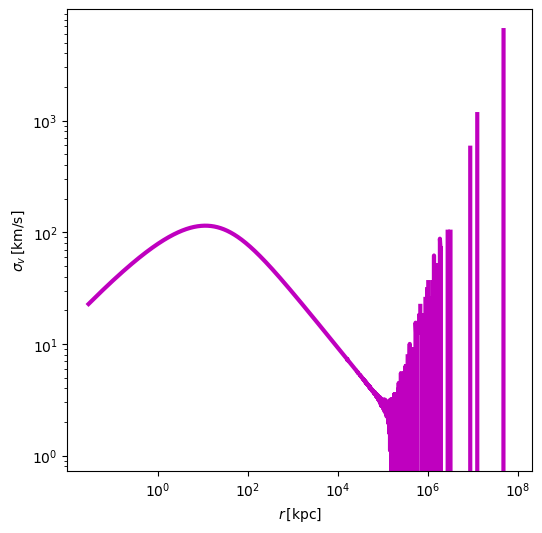

In [11]:
# plot the analytic velocity dispersion that we're trying to match in this problem
vv = analytic_velocity_dispersion(rvals)
plt.figure(figsize=(6,6))
plt.loglog(rvals, vv**0.5, 'm-', lw=3, label='Analytic')
plt.xlabel(r'$r\,[{\rm kpc}]$')
plt.ylabel(r'$\sigma_v\,[{\rm km/s}]$');

### Overall Strategy
The problem is that f(E) * sqrt(phi - E) spans many orders of magnitude, making it difficult to sample directly. In addition, because phi depends on r, and the sqrt couples phi and E. This means that if we want to use the transformation method, by numerically integrating our PDF to get a CDF and inverting it, we would naively have to do so for each value of phi, and thus r. That's completely impractical.

The trick I use is to decompose the sqrt term into sums of products of phi and terms with E in it. We can pll phi out of the sqrt term to see that sqrt(phi - E) = sqrt(phi) * sqrt(1 - E/phi). Then we can perform a binomial expansion of the sqrt term. To first order, this gives us sqrt(phi - E) = sqrt(phi) * (1 - E/2phi). So the conditional probability of a particle having a given velocity (from the statement of the problem) is proportional to sqrt(phi)*f(E) - 1/2sqrt(phi)*Ef(E). Ideally, this function should reasonably bound f(E) * sqrt(phi - E), allowing us to perform rejection sampling from the latter by using the former as a bounding function.

 We can integrate this bounding function to get a cumulative distribution function. This will look like a sum of two integrals, where we can pull the phi terms out of the integrals and then numerically integrate all of the E terms. This means we will have to precompute two grids - one for each of the two integral terms. For each value of r, we then just have to calculate the phi terms which are kind of like coefficients that set the linear combination of these numerical integrals that is used to bound the probability distribution for each particle.

In practice, to reasonably approximate this square root across the range of energies possible for each particle, we need to use many more than 2 terms. Luckily, we can generate the coefficients of this Taylor series analytically and multiply them with the relevant power of E. For each term, we just need to multiple by that same power of 1/phi. A dot product works nicely for this, since we can represent the CDFs for each grid as a matrix and the values of the powers of 1/phi as a vector.

I use a 20 term Taylor series here, with a slight "softening parameter" to make absolutely sure that this bounding function is everywhere greater than the function itself. In practice, the functino so well approximates the analytical expression that there's no need to do rejection sampling - we can inverse transform sample our bounding function and be sure that nearly no points will ever be rejected due to the goodness of the approximation.

In [12]:
def f_E(E):
    '''
    Function that computes the distribution function for a Hernquist profile given an
    arbitary array of energy values. Assumes the convention of positive potential energy,
    and thus positive energy

    Inputs:
        E: array of energy values
    Outputs:
        f_E: array of distribution function values
    '''
    E = -E
    q = (-E*aa/gn/mtot)**0.5
    v_g = (gn*mtot/aa)**0.5
    return mtot/8/(2**0.5)/(numpy.pi**3)/(aa**3)/(v_g**3) * \
           1/(1-q**2)**(5/2) * \
           (3 * numpy.arcsin(q) + q*(1-q**2)**0.5 * (1-2*q**2) * (8*q**4 - 8*q**2 - 3))

In [13]:
def binomial_term(p, n):
    """
    Compute the coefficients for the binomial expansion of (1-x)^p
    
    Inputs:
        p: power of the binomial (float)
        n: number of term to compute coefficient for (int)
    
    Returns:
        coefficient (float)
    """
    if n == 0:
        return 1
        
    coefficient = p
    for i in range(1, n):
        coefficient *= (p - i)
    
    sign = (-1)**n
    return sign * coefficient / factorial(n)

In [14]:
# compute all of the coefficients for the binomial expansion of our square root expression
p = 1/2
ncoeff = 20
coeffs = [binomial_term(p, n) for n in range(ncoeff)][::-1]
coeffs

[-0.003475278936093673,
 -0.003773159987758845,
 -0.004116174532100558,
 -0.004514514002948999,
 -0.004981532692909241,
 -0.005535036325454712,
 -0.006199240684509277,
 -0.0070078372955322266,
 -0.008008956909179688,
 -0.009273529052734375,
 -0.0109100341796875,
 -0.013092041015625,
 -0.01611328125,
 -0.0205078125,
 -0.02734375,
 -0.0390625,
 -0.0625,
 -0.125,
 -0.5,
 1]

In [15]:
# compute all of the integral terms in the binomial expansion
def tabulate_integral(E):
    """
    Function to compute the integral terms (precursor to the CDF we need) in the binomial expansion
    of the square root term in the expression for the conditional probability function.
    Inputs:
        E: array of energy values
    Outputs:
        integral: array of integral values
    """

    table = numpy.zeros((ncoeff, E.size))
    for i in range(ncoeff):
        # we want to only grab the "order"eth coefficient for the term we're computing
        table_coeffs = numpy.zeros_like(coeffs)
        table_coeffs[len(coeffs)-i-1] = coeffs[len(coeffs)-i-1]

        # evaluate the polynomial 
        table[i] = numpy.polyval(table_coeffs, E)

    # return the table of integral terms, represented by a matrix
    return table    

In [16]:
# set up an array of E values - this ranges from a very low number to the maximum value,
# which is the maximum total potential energy of a particle in the system (since for)
# any higher E, sqrt(phi-E) would be imaginary
E = numpy.logspace(-3, numpy.log10(round(gn*mtot/aa, 5)), 1000)

# generate the polynomial terms for each coefficient in our binomial expansion of the square root term
table = tabulate_integral(E)

# compute the integral of each term using the previous function, multiplied by the distribution function
cum_int = cumulative_trapezoid(table*f_E(E), E, axis=1, initial=0)

In [17]:
# now we just need a way to go from a uniform sample on the CDF's y-vaues
# mapped back to the x-values representing the energies
def inverse_cdf_lookup(cdf_values, target, x_values):
    """
    Function to binary search through CDF values to find inverse, yielding
    the energy that corresponds to a given cumulative probability value.
    
    Args:
        cdf_values: Sorted array of cumulative probabilities
        target: Cumulative probability value between 0 and 1
        x_values: Original x values corresponding to CDF (E in this case)
    """
    idx = numpy.searchsorted(cdf_values, target) # find the 
    
    # Since we may end up a bit far from a point where we have exactly
    # evaluated the energy/CDF value, we want to interpolate to get a
    # more accurate Energy out
    x0, x1 = x_values[idx-1], x_values[idx] # x values surrounding target
    y0, y1 = cdf_values[idx-1], cdf_values[idx] # evaluated CDF values surrounding target
    return x0 + (x1 - x0) * (target - y0) / (y1 - y0) # point we found, interpolated

In [18]:
potE = gn*mtot/(rvals+aa) # potential energy values for each particle

# initialize array to store the energy values that we will sample for each particle
Evals = numpy.zeros_like(rvals) 

# now, we loop through each particle and sample the probability distribution
for i, rr in enumerate(rvals):
    potEi = potE[i] # potential energy of a particle
    E_allowed = E<potEi # only keep the energy values that are less than the potential energy
    # the "phi vector" - powers of 1/phi to be dotted into the CDF to yield our
    # approximation to the probability distribution function. Again, one may
    # interpret these as "weights" to the tabulated integral terms we computed
    phi_vec = numpy.array([potEi**-i for i in range(ncoeff)])

    # compute the final CDF for this particle
    final_cum_dist = potEi**0.5*(cum_int.T*phi_vec).T # dot the "phi vector" into the integral terms
    total_cum_dist = numpy.sum(final_cum_dist, axis=0) # add together all of the "weighted terms"
    total_cum_dist = total_cum_dist[E_allowed] # only keep the Energy values that are less than the potential energy
    total_cum_dist /= total_cum_dist[-1] # normalize the CDF

    randints = my_randState.rand(1) # random number to sample the CDF
    E_trial = inverse_cdf_lookup(total_cum_dist, randints, E[E_allowed]) # inverse transform to get our E vlue
    Evals[i] = E_trial # save the E value

/var/folders/py/d6rmhh8d221_729lchpqs_mw0000gq/T/ipykernel_2559/3274226851.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Evals[i] = E_trial # save the E value


In [19]:
# with all of our E values in tow, we can easily compute the velocity
# of each particle since we also know the potential energy of each
v = numpy.sqrt(2*(potE-Evals))

In [20]:
# copying Mike's function from earlier, we can now generate the velocity vectors
# from our velocity magnitudes, assuming they are distributed isotropically

# random numbers for phi, theta, v_phi, v_theta:
new_randvec=my_randState.rand(2, nptot)

vel=numpy.zeros((nptot, 3), dtype='float32')

phir=2e0*numpy.pi*new_randvec[0]
thetar=numpy.arccos(1e0-2e0*new_randvec[1])

vel[:,0]=v*numpy.sin(thetar)*numpy.cos(phir)
vel[:,1]=v*numpy.sin(thetar)*numpy.sin(phir)
vel[:,2]=v*numpy.cos(thetar)

ttot=time.time()-time0
print('total time elapsed: {0:.2f} seconds'.format(ttot))

total time elapsed: 32.54 seconds


In [21]:
# take the dot product of v dot r to get the radial velocity of all of our particles.
# here, I use the definition of r hat = r vec / |r|, with r vec = xx^, yy^, zz^
vr = vel[:,0]*pos[:,0]/rvals + vel[:,1]*pos[:,1]/rvals + vel[:,2]*pos[:,2]/rvals

In [22]:
# since we already have the logarithmic radius bins, we can just reuse them.
# I use numpy.digitize to figure out which bin each particle belongs to
bin_indices = numpy.digitize(numpy.log10(rvals), binedges) - 1

# with that information, I can compute the velocity dispersion for all of the
# particles in a given bin. Iterating all bins, we get the binned velocity dispersion.
vr_dispersion = numpy.array([
        ((vr[bin_indices == i])**2).mean()**0.5
        for i in range(len(binedges)-1)
    ])

/var/folders/py/d6rmhh8d221_729lchpqs_mw0000gq/T/ipykernel_2559/1869449884.py:8: RuntimeWarning: Mean of empty slice.
  ((vr[bin_indices == i])**2).mean()**0.5
/Users/arg5965/micromamba/envs/astro-general/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/var/folders/py/d6rmhh8d221_729lchpqs_mw0000gq/T/ipykernel_2559/3648470541.py:8: RuntimeWarning: invalid value encountered in sqrt
  plt.loglog(rvals, vv**0.5, 'm--', lw=1.5, label='Analytic')


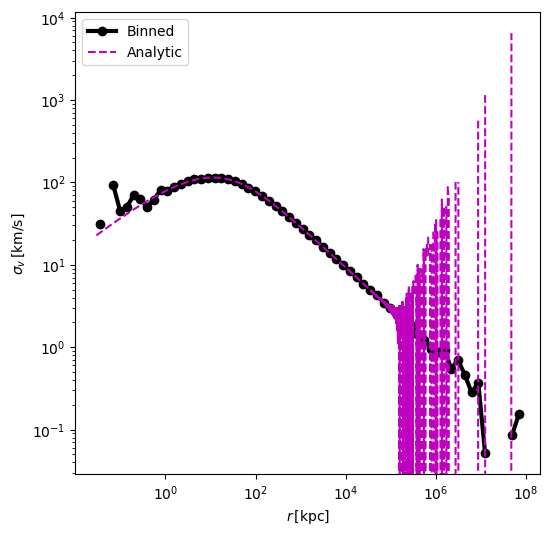

In [23]:
# finally, we can compare our binned velocity dispersion to the value from Hernquist that
# I plotted at the beginning. Since Hernquist actually provides the velocity dispersion squared,
# we need to square root it to compare to the binned velocity dispersion we computed.
vv = analytic_velocity_dispersion(rvals)
plt.figure(figsize=(6,6))
plt.loglog(bincenters, vr_dispersion, 'ko-', lw=3, label='Binned')
# plt.plot(bincenters[0], vr_dispersion[0], 'ko')
plt.loglog(rvals, vv**0.5, 'm--', lw=1.5, label='Analytic')
plt.legend()
plt.xlabel(r'$r\,[{\rm kpc}]$')
plt.ylabel(r'$\sigma_v\,[{\rm km/s}]$');

### Analysis/Final Thoughts
We see a very nice agreement between the binned velocity dispersion and the analytical value across most of the range in radius. This gives us a good amount of confidence that we have done the sampling correctly, demonstrating the power of approximating the PDF of a function using Taylor expansion and then subsequently applying inverse transform sampling.

My code seems quite efficient - many of the operations are vectorized, meaning that we can generate these velocities in about 30 seconds, which is quite nice. We could reasonably perform operations on 10 or even 100 times more particles in a very reasonable amount of CPU time on a standard laptop. Without performing detailed analysis of each line of code on the cell, it's difficult for me to say with certainty which line is running the slowest. However, my hunch is that there's not likely to be too much more room to optimize here. The binary search should be quite efficient, and most of the operations are vectorized. Probably, the majority of time is spend on creating the new arrays from the energy cutoff for each particle, which likely can't be avoided.

We do see some discrepancies at the very low-r end, and this might be for a couple of reasons. It might be possible that my sampling isn't very efficient at low r - however, from the binned statistics, I also note that there are only a few r values at most in the lowest r bins. This means that the function there is almost certainly dominated by Poisson noise, which is somewhat unavoidable without drastically increasing the total number of samples. On the high-r end, the binned function doesn't seem to completely match the analytic function either. However, the analytic function seems to be displaying some wild oscillatory behavior in this regime, meaning that the equation either isn't accurate there or suffers from numerical instability. Courtesy of Dionysis, a numerical integration seems to smooth out these irregularities, and his resulting numerically integrated Hernquist radial velocity dispersion profile very nicely matched mine at large r values.